In [4]:
# Imports and setup.
import numpy as np
import pypoisson
import torch
import trimesh
import sys
sys.path.append("..")
import grasp_opt
import grasp_utils
import mesh_utils
import fastgrasp as fg
import os.path as osp

from matplotlib import pyplot as plt
from nerf_shared import config_parser, utils

# Setup config (since we're not running from command line).
parser = config_parser.config_parser()

# Use the teddy_bear config, but change some filepaths.
args = parser.parse_args(args=[
    # '--config', '../nerf_shared/configs/power_drill.txt', 
    # '--basedir', '../nerf_shared/logs',
    # '--datadir', '../nerf_shared/data/isaac_power_drill'])
    '--config', '../nerf_shared/logs/isaac_teddy4/config.txt',
    '--basedir', '../nerf_shared/logs',
    '--datadir', '../nerf_shared/data/isaac_teddy'])

# nerf_shared requires us to default to cuda tensors.
torch.set_default_tensor_type(torch.cuda.FloatTensor)

# I <3 autoreload.
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load nerf models, params from checkpoint.
coarse_model, fine_model = utils.create_nerf_models(args)
optimizer = utils.get_optimizer(coarse_model, fine_model, args)
utils.load_checkpoint(coarse_model, fine_model, optimizer, args, checkpoint_index=-1)
images, poses, render_poses, hwf, i_split, K, bds_dict = utils.load_datasets(args)

# Override rendering bounds for fingers.
bds_dict = {'near': 0.05, 'far': 0.15}

renderer = utils.get_renderer(args, bds_dict)
H, W, focal = hwf

Found ckpts ['../nerf_shared/logs/isaac_teddy4/050000.tar', '../nerf_shared/logs/isaac_teddy4/100000.tar', '../nerf_shared/logs/isaac_teddy4/150000.tar', '../nerf_shared/logs/isaac_teddy4/200000.tar']
Reloading from ../nerf_shared/logs/isaac_teddy4/200000.tar
/scr-ssd/ksrini/nerf_grasping/notebooks-krishnan
Loaded blender (32, 200, 200, 4) torch.Size([40, 4, 4]) [200, 200, 317.1596119481254] ../nerf_shared/data/isaac_teddy
Not ndc!
{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_modules': OrderedDict(), 'perturb': 1.0, 'N_importance': 128, 'N_samples': 64, 'use_viewdirs': True, 'white_bkgd': False, 'raw_noise_std': 0.0, 'ndc': False, 'lindisp': False, 'near': 0.05, 'far': 0.15}


In [6]:
# Load ground truth mesh.
if args.config == 'teddy_bear/config.txt':
    gt_mesh = trimesh.load(
        'nerf_shared/data/isaac_teddy/bear_demo.glb',
        force='mesh')
    T = trimesh.transformations.euler_matrix(np.pi/2, 0., 0.,'rxyz')
elif args.config == '../nerf_shared/logs/isaac_teddy4/config.txt':
    gt_mesh = trimesh.load(
        '../assets/objects/meshes/isaac_teddy/isaac_bear.obj',
        force='mesh')
    T = trimesh.transformations.scale_matrix(1e-2, np.array([0,0,0]))
elif osp.split(args.config)[1] == 'power_drill.txt':
    gt_mesh = trimesh.load(
        '../assets/objects/meshes/power_drill/textured.obj',
        force='mesh')
    T = trimesh.transformations.scale_matrix(1, np.array([0,0,0]))
gt_mesh.apply_transform(T)
gt_mesh.show()

unable to load materials from: teady_bear.mtl
concatenating texture: may result in visual artifacts


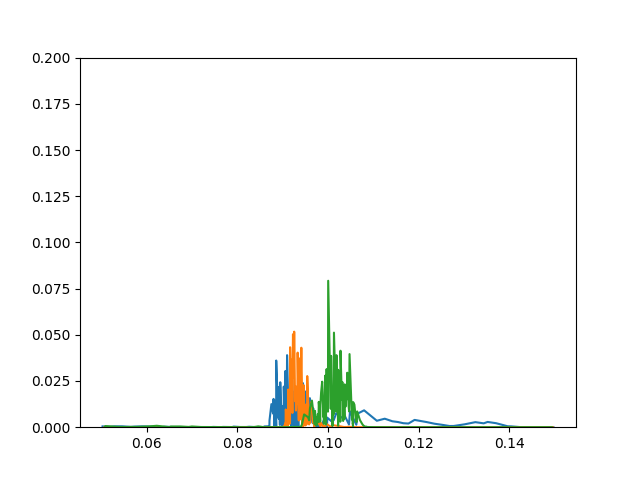

In [7]:
# Test grasp sampling
gp = np.array([[0.09, 0.09, 0.013], [-0.09, 0.09, 0.013], [0, -0.125, 0.013]]) + gt_mesh.centroid
grasp_points = torch.tensor(gp).reshape(1, 3, 3)
grasp_dirs = torch.tensor(gt_mesh.centroid) - grasp_points
grasp_vars = torch.cat([grasp_points, grasp_dirs], dim=-1)

rays, weights, z_vals = grasp_utils.get_grasp_distribution(grasp_vars,
                           coarse_model,
                           fine_model,
                           renderer)
plt.close('all')
plt.plot(z_vals[0, :, :].detach().cpu().numpy().T, weights[0,:,:].cpu().detach().numpy().T)
plt.ylim([0, 0.2])
plt.show()

In [9]:
grasp_points, grad_ests, grasp_mask = grasp_utils.sample_grasps(grasp_vars, 10, coarse_model, fine_model, renderer)
n_f = 3 
grasp_points = grasp_points.reshape(-1, n_f, 3)
normals = grad_ests.reshape(-1, n_f, 3)
G = grasp_opt.grasp_matrix(grasp_points, normals)

grasp_opt.min_norm_vector_in_facet(G[0].cpu().numpy())

(0.22516759570175246,
 array([[2.10529926e-08],
        [8.83167874e-08],
        [3.11806160e-08],
        [1.88274130e-08],
        [2.55561595e-08],
        [3.79984126e-01],
        [3.52302787e-08],
        [4.02804589e-01],
        [2.17211065e-01]]))

In [11]:
centroid = torch.tensor(gt_mesh.centroid).unsqueeze(0).repeat(10, 1)
grasps = torch.cat([grasp_points.reshape(-1, 9), normals.reshape(-1, 9), centroid], axis=-1)

mu = 1.0
result = np.zeros(10)
l = 10
t = fg.getLowerBoundsQHull(grasps.cpu().numpy(), mu, l, result)

In [12]:
result

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.62658049e-11,
       8.35123582e-11, 7.80568960e-11, 3.85379855e-04, 0.00000000e+00,
       6.45387754e-11, 0.00000000e+00])

CPU times: user 12.4 ms, sys: 15.2 ms, total: 27.6 ms
Wall time: 15.6 ms


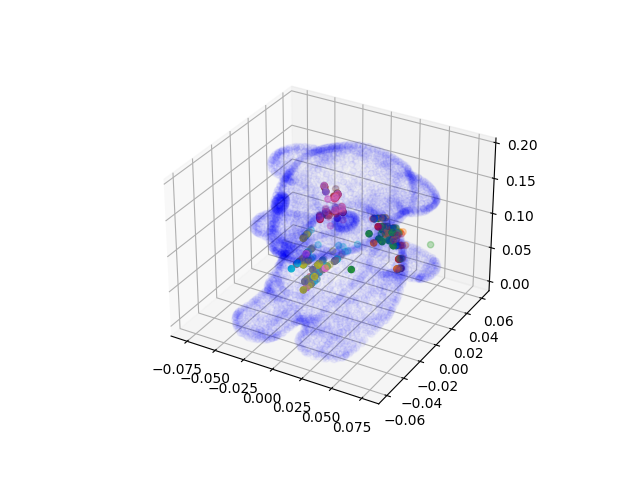

In [28]:
num_grasps = 10
var_batch = grasp_vars + 1e-2 * torch.randn(10, 3, 6)
%time grasp_points, grad_ests, grasp_mask = grasp_utils.sample_grasps(var_batch, \
                                                          num_grasps, \
                                                          coarse_model, \
                                                          fine_model, \
                                                          renderer)

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = grasp_points.cpu().detach().numpy().reshape(-1, 3, 3)

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, :, 0], gps_numpy[ii, :, 1], gps_numpy[ii, :, 2])

ax.scatter(gt_mesh.triangles_center[:, 0], gt_mesh.triangles_center[:, 1], gt_mesh.triangles_center[:, 2], c='blue', alpha=0.025)

plt.show()

# Sampling with different grasp metrics

## PSV

In [66]:
%%time
n_f = 3
gp = np.array([[0.09,0.09,-0.025], [0, -0.125, 0], [-0.09, 0.09, 0.025]]) + gt_mesh.centroid
grasp_points = torch.tensor(gp).reshape(1, 3, 3)
grasp_dirs = torch.tensor(gt_mesh.centroid) - grasp_points
grasp_vars = torch.cat([grasp_points, grasp_dirs], dim=-1)

mu_0 = torch.cat([grasp_points, grasp_dirs], dim=-1).reshape(-1)
Sigma_0 = torch.diag(torch.cat([torch.tensor([5e-3, 5e-3, 5e-3, 1e-3, 1e-3, 1e-3]) for _ in range(3)]))

cem_cost = lambda x: grasp_opt.grasp_cost(x, n_f, coarse_model, fine_model, renderer, cost_fn='psv')
constraint = lambda x: torch.all(x.abs() <= .15, dim=1)

with torch.no_grad():
    mu_f, Sigma_f = grasp_opt.optimize_cem(cem_cost, mu_0, Sigma_0, num_iters=15,
                                           elite_frac=.1, num_samples=500, constraint=constraint)

tensor(6.2648e-11) tensor(inf)
tensor([0.0052, 0.0041, 0.0035, 0.0029, 0.0018, 0.0017, 0.0014, 0.0013, 0.0012,
        0.0009, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0004, 0.0004, 0.0003]) tensor([ 0.0732,  0.0715,  0.0393, -0.0827, -0.0866,  0.0302,  0.0002, -0.0925,
         0.0578, -0.0020,  0.1150, -0.0026, -0.0669,  0.0811,  0.0869,  0.0827,
        -0.0860, -0.0238])
tensor(6.3976e-11) tensor(inf)
tensor([0.0037, 0.0029, 0.0024, 0.0020, 0.0017, 0.0014, 0.0012, 0.0010, 0.0009,
        0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002, 0.0002, 0.0001, 0.0001]) tensor([ 0.0711,  0.0699,  0.0416, -0.0717, -0.0782,  0.0223, -0.0052, -0.0795,
         0.0515,  0.0005,  0.1138,  0.0009, -0.0611,  0.0711,  0.0742,  0.0843,
        -0.0858, -0.0264])
tensor(2.4450e-08) tensor(inf)
tensor([3.6011e-03, 2.7593e-03, 2.0802e-03, 1.8624e-03, 1.4377e-03, 1.2832e-03,
        9.1924e-04, 8.4946e-04, 7.0756e-04, 6.2943e-04, 4.6532e-04, 3.3514e-04,
        3.1487e-04, 1.9813e-04, 1.2571e-04, 9.3025e

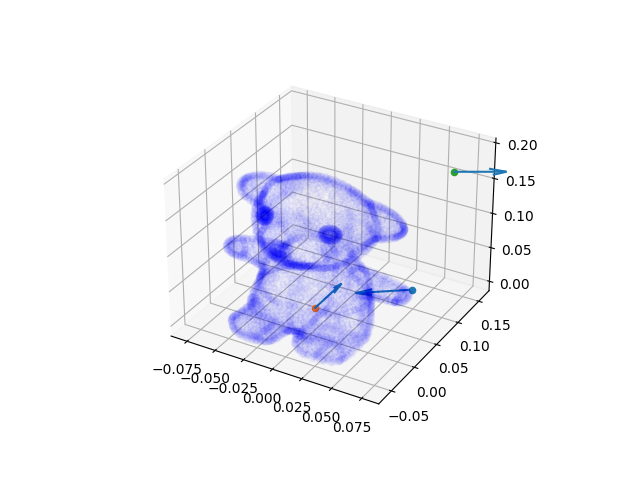

In [67]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = mu_f.cpu().detach().numpy().reshape(3, 6) + gt_mesh.centroid[:, None]

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, 0], gps_numpy[ii, 1], gps_numpy[ii, 2])
    ax.quiver(*[gps_numpy[ii, jj] for jj in range(6)],
          length=0.05, normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)

plt.show()

In [13]:
initial_pts = np.array([[ 0.1099,  0.0437,  0.2733],
                        [-0.0171, -0.1170,  0.2733],
                        [-0.0928,  0.0733,  0.2733]])

In [15]:
print(gp)

[[ 0.0898556   0.09412231  0.09963063]
 [-0.0901444   0.09412231  0.09963063]
 [-0.0001444  -0.12087769  0.09963063]]


In [16]:
print("Grasp Pts:\n", gps_numpy[:, :3], "\nGrasp Dirs:\n", gps_numpy[:, 3:])

Grasp Pts:
 [[ 0.05048395  0.05792721  0.04271419]
 [-0.03535814  0.06052882  0.05568466]
 [-0.00964258 -0.06320004  0.04302974]] 
Grasp Dirs:
 [[-0.08120517 -0.05609256 -0.01430834]
 [ 0.060706   -0.0723137  -0.04849519]
 [ 0.01232326  0.11947666 -0.00017375]]


In [19]:
pts = np.array([[0.0350,  0.0580,  0.1010],
         [ 0.0000, -0.0480,  0.0830],
         [-0.0390,  0.0580,  0.1010]])
norms = np.array([[-0.0350, -0.0580,  0.0000],
        [ 0.0000,  1.0000,  0.0000],
        [ 0.0390, -0.0580,  0.0000]])

In [20]:
pts

array([[ 0.035,  0.058,  0.101],
       [ 0.   , -0.048,  0.083],
       [-0.039,  0.058,  0.101]])

In [21]:
norms

array([[-0.035, -0.058,  0.   ],
       [ 0.   ,  1.   ,  0.   ],
       [ 0.039, -0.058,  0.   ]])

## MSV

In [37]:
%%time
n_f = 3
gp = np.array([[0.09,0.09,-0.025], [-0.09, 0.09, 0.025], [0, -0.125, 0]]) + gt_mesh.centroid
grasp_points = torch.tensor(gp).reshape(1, 3, 3)
grasp_dirs = torch.tensor(gt_mesh.centroid) - grasp_points
grasp_vars = torch.cat([grasp_points, grasp_dirs], dim=-1)

mu_0 = torch.cat([grasp_points, grasp_dirs], dim=-1).reshape(-1)
Sigma_0 = torch.diag(torch.cat([torch.tensor([5e-3, 5e-3, 5e-3, 1e-3, 1e-3, 1e-3]) for _ in range(3)]))

cem_cost = lambda x: grasp_opt.grasp_cost(x, n_f, coarse_model, fine_model, renderer, cost_fn='msv')
constraint = lambda x: torch.all(x.abs() <= .15, dim=1)

with torch.no_grad():
    mu_f, Sigma_f = grasp_opt.optimize_cem(cem_cost, mu_0, Sigma_0, num_iters=10,
                                           elite_frac=.1, num_samples=750, constraint=constraint)

1 tensor(67)
2 tensor(148)
3 tensor(215)
4 tensor(282)
5 tensor(349)
6 tensor(409)
7 tensor(463)
8 tensor(529)
9 tensor(594)
10 tensor(649)
11 tensor(710)
12 tensor(750)
tensor(-0.0116) tensor(inf)
tensor([0.0052, 0.0041, 0.0037, 0.0030, 0.0028, 0.0023, 0.0020, 0.0017, 0.0014,
        0.0011, 0.0010, 0.0009, 0.0008, 0.0006, 0.0006, 0.0005, 0.0004, 0.0003]) tensor([ 0.0733,  0.0775,  0.0406, -0.0845, -0.0861,  0.0344, -0.0658,  0.0747,
         0.0625,  0.0899, -0.0847, -0.0301,  0.0044, -0.0775,  0.0612,  0.0029,
         0.1151, -0.0058])
1 tensor(412)
2 tensor(750)
tensor(-0.0121) tensor(inf)
tensor([0.0060, 0.0045, 0.0037, 0.0026, 0.0021, 0.0017, 0.0014, 0.0012, 0.0010,
        0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002, 0.0002]) tensor([ 0.0745,  0.0725,  0.0361, -0.0836, -0.0831,  0.0399, -0.0674,  0.0688,
         0.0539,  0.0860, -0.0823, -0.0344,  0.0135, -0.0769,  0.0599,  0.0067,
         0.1100,  0.0007])
1 tensor(525)
2 tensor(750)
tensor(-0.0118) tensor

In [36]:
## Check distance to boudary of bear
trimesh.proximity.signed_distance(gt_mesh, gps_numpy[:, :3])

array([-0.02218144, -0.02885224, -0.02039768])

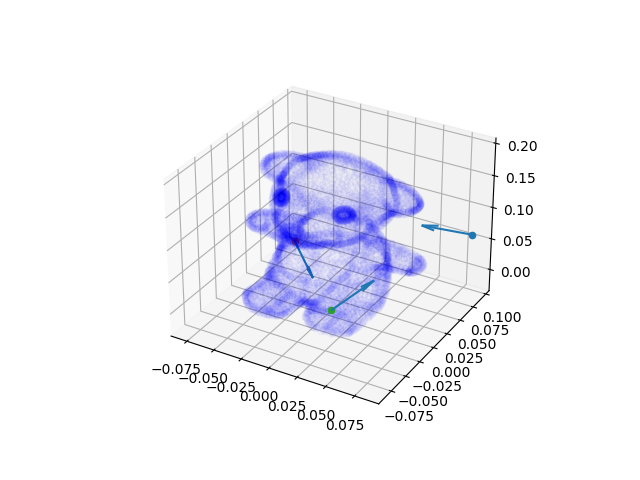

In [38]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = mu_f.cpu().detach().numpy().reshape(3, 6)

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, 0], gps_numpy[ii, 1], gps_numpy[ii, 2])
    ax.quiver(*[gps_numpy[ii, jj] for jj in range(6)],
          length=0.05, normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)

plt.show()

## Ferrari-Canny

In [13]:
%%time
n_f = 3
grasp_points = torch.tensor([[0.09,0.09,-0.025], [-0.09, 0.09, 0.025], [0, -0.125, 0]]).reshape(1, 3, 3)
# grasp_points = 1e-1 * torch.randn(1, 3, 3)
grasp_dirs = -grasp_points

mu_0 = torch.cat([grasp_points, grasp_dirs], dim=-1).reshape(-1)
Sigma_0 = torch.diag(torch.cat([torch.tensor([5e-3, 5e-3, 5e-3, 1e-3, 1e-3, 1e-3]) for _ in range(3)]))

cem_cost = lambda x: grasp_opt.grasp_cost(x, n_f, coarse_model, fine_model, renderer, cost_fn='l1')

with torch.no_grad():
    mu_f, Sigma_f = grasp_opt.optimize_cem(cem_cost, mu_0, Sigma_0, num_iters=10,
                                           elite_frac=.1, num_samples=750)

tensor(-0.0005, dtype=torch.float64) tensor(inf, dtype=torch.float64)
tensor([0.0087, 0.0082, 0.0068, 0.0055, 0.0049, 0.0042, 0.0034, 0.0030, 0.0026,
        0.0014, 0.0013, 0.0011, 0.0009, 0.0007, 0.0007, 0.0006, 0.0005, 0.0003]) tensor([ 0.0809,  0.0787, -0.0366, -0.0869, -0.0918,  0.0304, -0.0944,  0.0932,
         0.0438,  0.0901, -0.0937, -0.0199,  0.0051, -0.1298,  0.0108, -0.0012,
         0.1242,  0.0054])
tensor(-0.0037, dtype=torch.float64) tensor(inf, dtype=torch.float64)
tensor([0.0113, 0.0095, 0.0069, 0.0061, 0.0052, 0.0044, 0.0035, 0.0026, 0.0020,
        0.0012, 0.0009, 0.0007, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002]) tensor([ 0.0665,  0.0652, -0.0336, -0.0795, -0.0964,  0.0298, -0.0921,  0.0846,
         0.0536,  0.0930, -0.0849, -0.0163,  0.0161, -0.1399,  0.0136,  0.0004,
         0.1247,  0.0070])
tensor(-0.0002, dtype=torch.float64) tensor(inf, dtype=torch.float64)
tensor([0.0146, 0.0100, 0.0091, 0.0061, 0.0043, 0.0038, 0.0037, 0.0033, 0.0016,
        0.0011

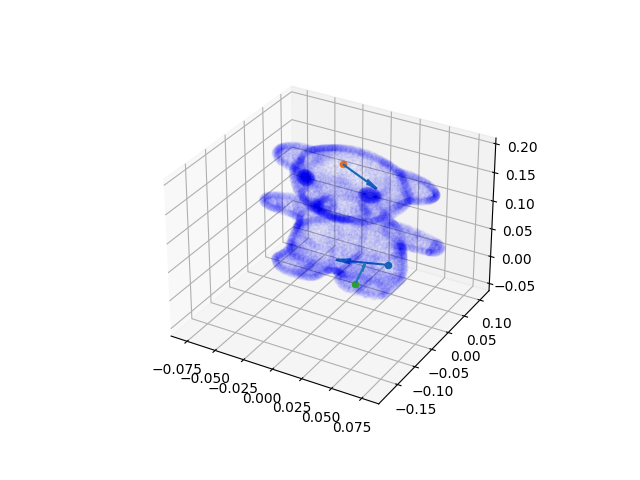

In [15]:
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = mu_f.cpu().detach().numpy().reshape(3, 6)

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, 0], gps_numpy[ii, 1], gps_numpy[ii, 2])
    ax.quiver(*[gps_numpy[ii, jj] for jj in range(6)],
          length=0.05, normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)

plt.show()

CPU times: user 10.2 ms, sys: 11.9 ms, total: 22.1 ms
Wall time: 12.3 ms


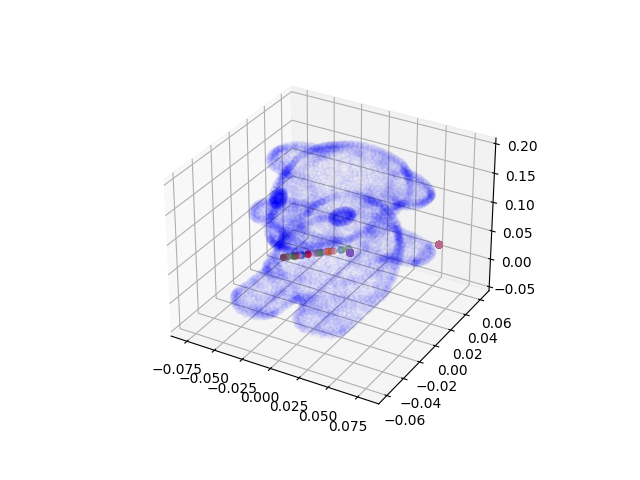

In [18]:
# Sample some grasps + visualize
# n = mu_f.shape[0]
num_grasps = 25
# x = (mu_f.reshape(1, n, 1)
#                  + torch.linalg.cholesky(Sigma_f).reshape(1, n, n)
#                  @ torch.randn(num_samples, n, 1)).reshape(num_samples, n)
# x = x.reshape(-1, n_f, 6)

x = mu_f.reshape(-1, n_f, 6)
%time grasp_points, grad_ests, grasp_mask = grasp_utils.sample_grasps(x, \
                                                          num_grasps, \
                                                          coarse_model, \
                                                          fine_model, \
                                                          renderer)


plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = grasp_points.cpu().detach().numpy().reshape(-1, 3, 3)

for ii in range(gps_numpy.shape[0]):
    ax.scatter(gps_numpy[ii, :, 0], gps_numpy[ii, :, 1], gps_numpy[ii, :, 2])

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)

plt.show()

In [17]:
# Test grasp sampling

rays, weights, z_vals = grasp_utils.get_grasp_distribution(mu_f.reshape(1,3,6),
                           coarse_model,
                           fine_model,
                           renderer)
plt.close('all')
for ii in range(3):
    plt.plot(z_vals[0, ii, :].detach().cpu().numpy().T, weights[0,ii,:].cpu().detach().numpy().T,
             label="Finger "+str(ii+1))
plt.ylim([0, 0.2])
plt.title("Grasp Point Distribution")
plt.xlabel("Distance to Surface [m]")
plt.ylabel("Probability Mass")
plt.legend()
plt.show()

NameError: name 'mu_f' is not defined

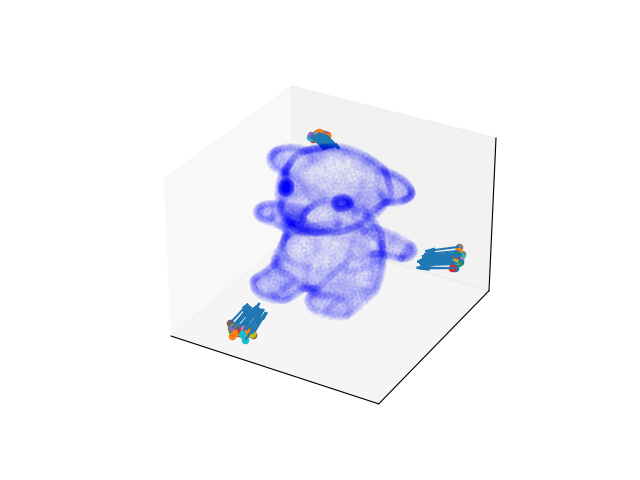

In [112]:
# Visualize point/normal distribution
n = mu_f.shape[0]
num_samples = 25
x = (mu_f.reshape(1, n, 1)
                 + torch.linalg.cholesky(Sigma_f).reshape(1, n, n)
                 @ torch.randn(num_samples, n, 1)).reshape(num_samples, n)
x = x.reshape(-1, n_f, 6)

plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

gps_numpy = x.cpu().detach().numpy().reshape(-1, 3, 6)

for bb in range(num_samples):
    for ii in range(3):
        ax.scatter(gps_numpy[bb, ii, 0], gps_numpy[bb, ii, 1], gps_numpy[bb, ii, 2])
        ax.quiver(*[gps_numpy[bb, ii, jj] for jj in range(6)],
              length=0.05, normalize=True)

ax.scatter(*[gt_mesh.triangles_center[:, ii] for ii in range(3)], c='blue', alpha=0.025)
# Hide grid lines
ax.grid(False)

# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()